# pandas 应用篇

In [1]:
import numpy as np
# 导入相关包
%matplotlib inline
# 绘图包
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

> **25 部被评次数最多的电影?**

In [2]:
mosted_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
mosted_rated

title
Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Fu

以上语句的SQL语句就是：
```sql
SELECT title, count(1)
FROM lens
GROUP BY title
ORDER BY 2 DESC
LIMIT 25;
```

In [3]:
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Titanic (1997)      

> **评分普遍较高的电影?**

**聚合函数 agg 非常有用, 传入一个词典，词典的 key 就是我们要做聚合的那一列， 词典的 value 是一个 list，list里面包含要对该列进行的聚合操作。**

> We can use the agg method to pass a dictionary specifying the columns to aggregate (as keys) and a list of functions we'd like to apply.


In [4]:
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
print movie_stats.head()

                          rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390


In [5]:
print movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

                                           rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0


**注意上面 sort_values() 排序主键参数，使用的是 ('rating', 'mean'), 是一个 tuple， 为什么？ 因为这里经过聚合之后，返回的 DataFrame 的列是多层次索引的！MultiIndex， 因此我们需要传入 tuple 来排序。**

In [6]:
atleast_100 = movie_stats['rating']['size'] >= 100
print(type(atleast_100))
print movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

<class 'pandas.core.series.Series'>
                                       rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, T

以上pandas代码对应的SQL：
```sql
SELECT title, COUNT(1) size, AVG(rating) mean
FROM lens
GROUP BY title
HAVING COUNT(1) >= 100
ORDER BY 3 DESC
LIMIT 15;
```

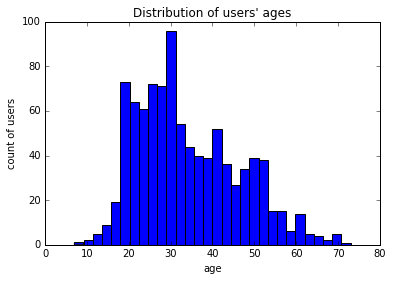

In [7]:
users.age.plot.hist(bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');

## pandas.cut allows you to bin numeric data
利用 pandas 可以对 数值类型的 数据进行分组! 这样可以添加一列,用于指明没一个数据属于哪个组!

In [8]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
lens['age_group'] = pd.cut(lens.age, range(0, 81, 10), right=False, labels=labels)
print lens[['age', 'age_group']].drop_duplicates()[:10]

      age age_group
0      60     60-69
397    21     20-29
459    33     30-39
524    30     30-39
782    23     20-29
995    29     20-29
1229   26     20-29
1664   31     30-39
1942   24     20-29
2270   32     30-39


In [9]:
print lens.groupby('age_group').agg({'rating': [np.size, np.mean]})

          rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746


In [10]:
most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]

以上选择 评论最多的 前 50 个数据的SQL语句:
```sql
CREATE TABLE most_50 AS (
    SELECT movie_id, COUNT(1)
    FROM lens
    GROUP BY movie_id
    ORDER BY 2 DESC
    LIMIT 50
);
```

In [11]:
lens.set_index('movie_id', inplace=True)
by_age = lens.loc[most_50.index].groupby(['title', 'age_group'])
by_age.rating.mean().head(15)

title                 age_group
Air Force One (1997)  10-19        3.647059
                      20-29        3.666667
                      30-39        3.570000
                      40-49        3.555556
                      50-59        3.750000
                      60-69        3.666667
                      70-79        3.666667
Alien (1979)          10-19        4.111111
                      20-29        4.026087
                      30-39        4.103448
                      40-49        3.833333
                      50-59        4.272727
                      60-69        3.500000
                      70-79        4.000000
Aliens (1986)         10-19        4.050000
Name: rating, dtype: float64

## unstack 函数
unstack 函数可以取消规定的多层次索引(**默认情况下, groupby 函数会把分组依据的字段作为分组后的索引,由于这里使用的是两个字段来分组,因此索引成为了 多层次索引**)

In [12]:
print by_age.rating.mean().unstack(1).fillna(0)[10:20]

age_group                          0-9     10-19     20-29     30-39  \
title                                                                  
E.T. the Extra-Terrestrial (1982)  0.0  3.680000  3.609091  3.806818   
Empire Strikes Back, The (1980)    4.0  4.642857  4.311688  4.052083   
English Patient, The (1996)        5.0  3.739130  3.571429  3.621849   
Fargo (1996)                       0.0  3.937500  4.010471  4.230769   
Forrest Gump (1994)                5.0  4.047619  3.785714  3.861702   
Fugitive, The (1993)               0.0  4.320000  3.969925  3.981481   
Full Monty, The (1997)             0.0  3.421053  4.056818  3.933333   
Godfather, The (1972)              0.0  4.400000  4.345070  4.412844   
Groundhog Day (1993)               0.0  3.476190  3.798246  3.786667   
Independence Day (ID4) (1996)      0.0  3.595238  3.291429  3.389381   

age_group                             40-49     50-59     60-69     70-79  
title                                                      

以上函数, unstack(1) 完成对 多层索引中第二个字段的 unstack, 即现在的索引变成了 title 一个单索引了!

In [14]:
# print by_age.rating.mean().unstack(0).fillna(0)

> **选择哪些电影是男性和女性评价最不一致的?**

如果像SQL一样思考,首先是对电影分组,然后每一部电影中男生评分的均值,女生评分的均值,最后选出差异最大的那些组!

```sql
SELECT title, AVG(IF(sex = 'F', rating, NULL)), AVG(IF(sex = 'M', rating, NULL))
FROM lens
GROUP BY title;
```

## pivot_table 函数

In [15]:
lens.reset_index('movie_id', inplace=True)
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['sex'],
                           values='rating',
                           fill_value=0)
print pivoted.head()

sex                                F         M
movie_id title                                
1        Toy Story (1995)   3.789916  3.909910
2        GoldenEye (1995)   3.368421  3.178571
3        Four Rooms (1995)  2.687500  3.108108
4        Get Shorty (1995)  3.400000  3.591463
5        Copycat (1995)     3.772727  3.140625


In [17]:
pivoted['diff'] = pivoted.M - pivoted.F
print pivoted.head()

sex                                F         M      diff
movie_id title                                          
1        Toy Story (1995)   3.789916  3.909910  0.119994
2        GoldenEye (1995)   3.368421  3.178571 -0.189850
3        Four Rooms (1995)  2.687500  3.108108  0.420608
4        Get Shorty (1995)  3.400000  3.591463  0.191463
5        Copycat (1995)     3.772727  3.140625 -0.632102


In [21]:
pivoted.reset_index('movie_id', inplace=True)
print pivoted.head()

sex  index              title  movie_id         F         M      diff
0        0   Toy Story (1995)         1  3.789916  3.909910  0.119994
1        1   GoldenEye (1995)         2  3.368421  3.178571 -0.189850
2        2  Four Rooms (1995)         3  2.687500  3.108108  0.420608
3        3  Get Shorty (1995)         4  3.400000  3.591463  0.191463
4        4     Copycat (1995)         5  3.772727  3.140625 -0.632102


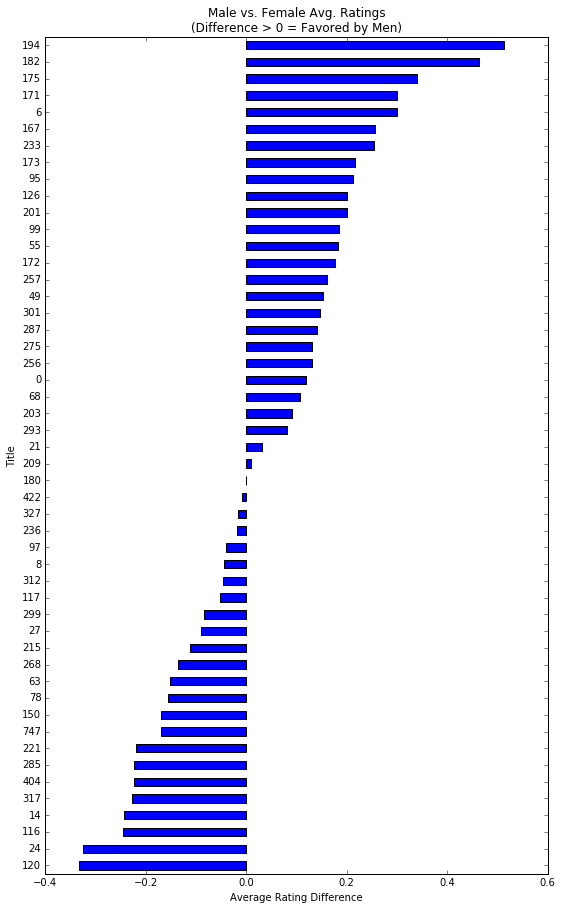

In [22]:
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');

# 参考
 - [Working with DataFrames](http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/)